In [1]:
# SSD multi-object detection code, heavily borrowed and modified from the tutorial:
# https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

import torch
from IPython.display import display
import os 
import sys
import random
import shutil
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from os import listdir, path
from os.path import isfile, join
import cv2
from torchvision import transforms
import zipfile

In [ ]:
# Utility functions:

In [2]:
# Utility function to move images 
def copy_files_to_folder(src, list_of_files, destination_folder):
    for f in list_of_files:
        #print(f)
        try:
            shutil.copy(path.join(src, f), destination_folder) 
            #print(path.join(src, f))
        except:
            #print(f)
            assert False

In [3]:
# Utility function to detect objects:
def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    print("LABELS: ", det_labels)
    print("SCORES: ", det_scores)

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./FreeSans.ttf", 15)


    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image


In [4]:
# Utility function to add padding around image
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result
    

In [ ]:
# Code to train and test the SSD model:

In [3]:
# Unzip dataset
with zipfile.ZipFile('data/lego_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [5]:
# Load annotations and images
lego_images_dir = './data/images'
lego_annotations_dir = './data/annotations'
images_list_all = [f for f in listdir(lego_images_dir) if isfile(join(lego_images_dir, f))]
labels_list_all = [ff for ff in listdir(lego_annotations_dir) if isfile(join(lego_annotations_dir, ff))]
images_list_all.sort()
labels_list_all.sort()


In [6]:
# Split dataset into test and train sets
train_set_length = int(len(images_list_all) *0.75)
test_set_length = len(images_list_all) - train_set_length

print("Train dataset length: ", train_set_length)
print("Test dataset length: ", test_set_length)

train_set_img = random.sample(images_list_all, train_set_length)
train_set_anno = [x[:5] + '.xml' for x in train_set_img]

test_set_img = [x for x in images_list_all if x not in train_set_img]
test_set_anno = [x[:5] + '.xml' for x in test_set_img]

test_set_img.sort()
test_set_anno.sort() 
train_set_img.sort()
train_set_anno.sort()

# compare train and test dataset lengths
print(len(train_set_img))
print(len(test_set_img))

# common sense check that no data is repeating accross train and test datasets
for x in train_set_img:
    if x in test_set_img:
        print("repeating")
        

Train dataset length:  2285
Test dataset length:  762
2285
762


In [7]:
# Save all train and test file names in a txt file
file = "ssd_pytorch/data/Train/trainval.txt"
os.remove(file) if os.path.exists(file) else None

f= open(file,"w+")
for x in train_set_img:
    x = x[:5]
    f.write(x + "\n")
f.close()

file = "ssd_pytorch/data/Test/test.txt"
os.remove(file) if os.path.exists(file) else None

f= open(file,"w+")
for x in test_set_img:
    x = x[:5]
    f.write(x + "\n")
f.close()

In [8]:
# Copy train set 
dataset_train_img = './ssd_pytorch/data/Train/JPEGImages/'
dataset_train_anno = './ssd_pytorch/data/Train/Annotations/'
copy_files_to_folder(lego_images_dir, train_set_img, dataset_train_img)
copy_files_to_folder(lego_annotations_dir, train_set_anno, dataset_train_anno)

# Copy test set 
dataset_test_img = './ssd_pytorch/data/Test/JPEGImages/'
dataset_test_anno = './ssd_pytorch/data/Test/Annotations/'
copy_files_to_folder(lego_images_dir, test_set_img, dataset_test_img)
copy_files_to_folder(lego_annotations_dir, test_set_anno, dataset_test_anno)


In [9]:
# SSD Pytorch
%cd ssd_pytorch

/home/mg/programming/Multi-object-detection-lego/ssd_pytorch


In [11]:
# Parase dataset and create JSON files with:
# list of the absolute filepaths of all images
# list of dictionaries containing ground truth objects, bounding boxes in absolute boundary coordinates
# label_map, the label-to-index dictionary with which the labels are encoded in the previous JSON file. This dictionary is also available in utils.py and directly importable.
#from utils import create_data_lists
from utils import *
create_data_lists(train_path='data/Train', test_path='data/Test', output_folder='data')



There are 2273 training images containing a total of 6819 objects. Files have been saved to /home/mg/programming/Multi-object-detection-lego/ssd_pytorch/data.

There are 762 test images containing a total of 2286 objects. Files have been saved to /home/mg/programming/Multi-object-detection-lego/ssd_pytorch/data.


In [16]:
# Train the model
# If checkpoint_ssd300.pth.tar does not exist, will train new model
# Otherwise will continue from last saved checkpoint
!python3 train.py


Loaded checkpoint from epoch 1.

/home/mg/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
LR is:  0.001
/home/mg/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch: [1][0/142]	Batch Time 3.389 (3.389)	Data Time 0.469 (0.469)	Loss 5.3638 (5.3638)	
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thr

In [19]:
# Enable cuda and load model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


Loaded checkpoint from epoch 3.



LABELS:  ['brick_2x2', 'brick_2x4', 'brick_2x4']
SCORES:  [tensor([0.8842, 0.7138, 0.5473], device='cuda:0', grad_fn=<CatBackward>)]


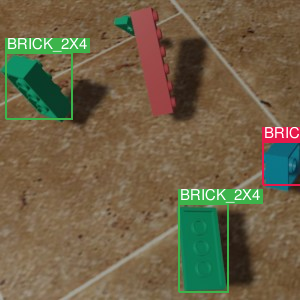

In [29]:
# Detect objects in a single image
img_path = 'detection/' + '3.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
#original_image = add_margin(original_image, 50, 50, 50, 50, (255,255,255)) #check this!
detect(original_image, min_score=0.5, max_overlap=0.5, top_k=200)

LABELS:  ['brick_2x2', 'brick_2x2', 'brick_2x2', 'brick_2x2', 'brick_2x4', 'plate_2x2', 'plate_2x2', 'plate_2x2']
SCORES:  [tensor([0.5695, 0.3764, 0.2959, 0.2082, 0.3005, 0.3626, 0.2263, 0.2256],
       device='cuda:0', grad_fn=<CatBackward>)]


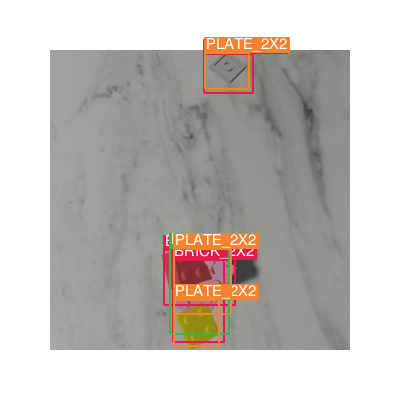

LABELS:  ['brick_2x2', 'brick_2x4', 'brick_1x6', 'brick_1x6', 'brick_1x6', 'plate_2x2', 'plate_2x4']
SCORES:  [tensor([0.3200, 0.3690, 0.5594, 0.2880, 0.2305, 0.2575, 0.4041],
       device='cuda:0', grad_fn=<CatBackward>)]


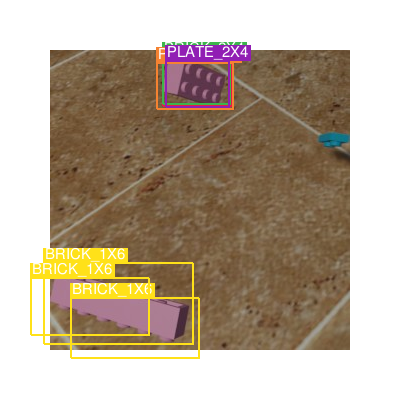

LABELS:  ['brick_2x2', 'brick_2x2', 'brick_2x4', 'brick_2x4', 'brick_1x6', 'plate_2x2', 'plate_2x2', 'plate_2x4']
SCORES:  [tensor([0.6510, 0.3144, 0.4491, 0.3640, 0.2640, 0.2353, 0.2145, 0.2001],
       device='cuda:0', grad_fn=<CatBackward>)]


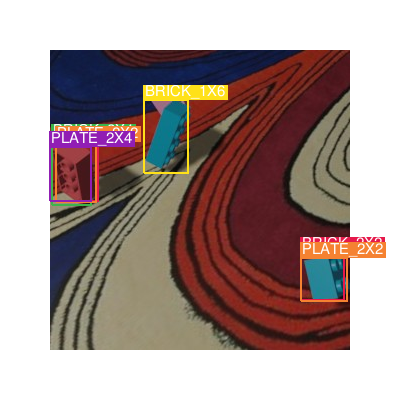

LABELS:  ['brick_2x2', 'brick_2x2', 'brick_2x4', 'brick_2x4', 'brick_1x6', 'plate_2x2', 'plate_2x2']
SCORES:  [tensor([0.4538, 0.4282, 0.3982, 0.2989, 0.2721, 0.5702, 0.2102],
       device='cuda:0', grad_fn=<CatBackward>)]


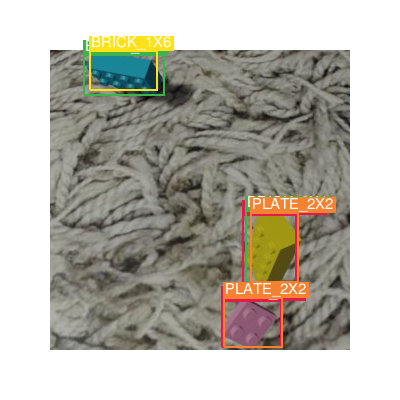

LABELS:  ['brick_2x2', 'brick_2x4', 'brick_1x6', 'brick_1x6', 'brick_1x6', 'brick_1x6', 'plate_2x2', 'plate_2x4', 'plate_2x4']
SCORES:  [tensor([0.6728, 0.2649, 0.6368, 0.6016, 0.2558, 0.2335, 0.3049, 0.2698, 0.2446],
       device='cuda:0', grad_fn=<CatBackward>)]


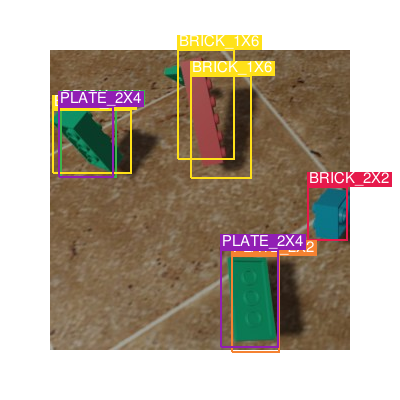

In [30]:
# Detect objects in an image directory
directory = './detection'
path, dirs, files = next(os.walk(directory))
file_count = len(files)
images1 =  []
for x in files:
    img_path = directory + '/' + x
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    original_image = add_margin(original_image, 50, 50, 50, 50, (255,255,255))
    display(detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200))


In [22]:
# Detect from webcam
!python3 detect_webcam.py


Loaded checkpoint from epoch 147.

LABELS:  ['background']
SCORES:  [tensor([0.], device='cuda:0')]
LABELS:  ['background']
SCORES:  [tensor([0.], device='cuda:0')]
LABELS:  ['background']
SCORES:  [tensor([0.], device='cuda:0')]
LABELS:  ['background']
SCORES:  [tensor([0.], device='cuda:0')]
/home/mg/programming/Multi-object-detection-lego/ssd_pytorch/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/home/mg/programming/Multi-object-detection-lego/ssd_pytorch/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.6314], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  

LABELS:  ['brick_1x6']
SCORES:  [tensor([0.9320], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8751], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8331], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.9287], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.7143], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8841], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8165], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8536], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8084], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8377], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.9092], device='cuda:0', grad_fn=<CatB

LABELS:  ['brick_1x6', 'brick_1x6', 'brick_1x6', 'brick_1x6', 'plate_2x4']
SCORES:  [tensor([0.8842, 0.6416, 0.5742, 0.3911, 0.4382], device='cuda:0',
       grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6', 'brick_1x6', 'brick_1x6', 'plate_2x4']
SCORES:  [tensor([0.8695, 0.3739, 0.3419, 0.7542], device='cuda:0',
       grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8737], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8555], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8660], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8105], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.6237], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8465], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['brick_1x6']
SCORES:  [tensor([0.8345], device='cuda:0', grad_fn=<CatBackward0>)]
LABELS:  ['